In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from os.path import dirname, join as pjoin
import scipy.io as sio
import h5py
import hdf5storage
import random
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from PIL import Image

Загрузим обучающий датасет:

In [2]:
housenumbers_train_orig = tf.keras.utils.get_file(
    origin='http://ufldl.stanford.edu/housenumbers/train.tar.gz',
    fname='train',
    untar=True
)
housenumbers_train_path = pathlib.Path(housenumbers_train_orig)
print(housenumbers_train_path)

/home/maxim/.keras/datasets/train


Загружаем тестовый датасет:

In [3]:
housenumbers_test_orig = tf.keras.utils.get_file(
    origin='http://ufldl.stanford.edu/housenumbers/test.tar.gz',
    fname='test',
    untar=True
)
housenumbers_test_path = pathlib.Path(housenumbers_test_orig)
print(housenumbers_test_path)

/home/maxim/.keras/datasets/test


Загрузим train и test .mat файлы, которые содержат изображения номеров домов.

In [4]:
housenumbers_train32_orig = tf.keras.utils.get_file(
    origin='http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
    fname='train_32x32'
)
housenumbers_train32_path = pathlib.Path(housenumbers_train32_orig)
print(housenumbers_train32_path)

/home/maxim/.keras/datasets/train_32x32


In [5]:
housenumbers_test32_orig = tf.keras.utils.get_file(
    origin='http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
    fname='test_32x32'
)
housenumbers_test32_path = pathlib.Path(housenumbers_test32_orig)
print(housenumbers_test32_path)

/home/maxim/.keras/datasets/test_32x32


In [6]:
def show_images_grid(images_array):
    fig = plt.figure(figsize = (20, 20))
    number_of_images = images_array.shape[0]
    for i in range(1, 5):
        idx = random.randint(0, number_of_images - 1)
        row_plot = fig.add_subplot(2,4,i)
        row_plot.imshow(images_array[idx])
    plt.show()
    plt.close()

Загрузим данные в память.

In [7]:
# with h5py.File(str(housenumbers_train_path) + '/digitStruct.mat', 'r') as f:
#     print(f.keys())
#     print(f['#refs#'])
#     print(f['digitStruct']['name'][0, 0])
train32_mat = sio.loadmat('/home/maxim/.keras/datasets/train_32x32')

test32_mat = sio.loadmat('/home/maxim/.keras/datasets/test_32x32')

In [8]:
train32_x = train32_mat['X']
train32_y = train32_mat['y']

test32_x = test32_mat['X']
test32_y = test32_mat['y']

x_train, y_train = train32_x.transpose((3,0,1,2)), train32_y[:,0]

x_test, y_test = test32_x.transpose((3,0,1,2)), test32_y[:,0]

In [9]:
# show random train images
# show_images_grid(x_train)

def unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    # print list 
    for x in unique_list: 
        print(x)
        
unique(y_test)

5
2
1
10
6
9
8
3
4
7


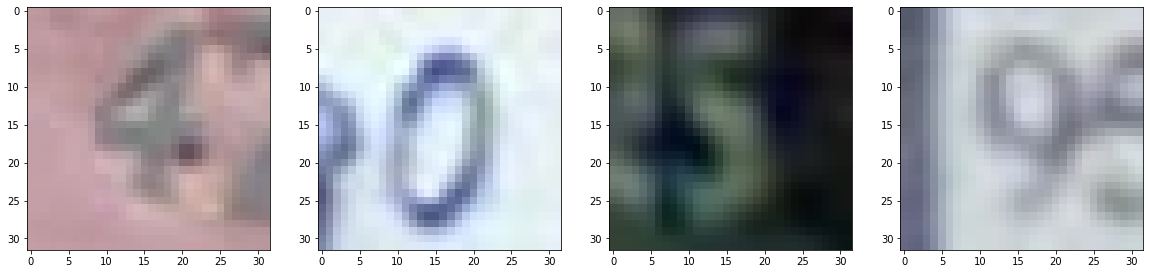

In [10]:
# show random test images
show_images_grid(x_test)

Отобразим несколько случайных изображений.

Также определим flow изображений при помощи ImageDataGenerator, т.е. разобьём на x'ы и y'ки.

In [11]:
VALIDATION_SET_RATE = 0.05

# define image generators for train, validation and test set
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SET_RATE
)

validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SET_RATE
)

test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SET_RATE
)

BATCH_SIZE = 32
IMG_HEIGHT = 32
IMG_WIDTH = 32
IMG_CHANNELS = 3
EPOCHS_COUNT = 5

num_classes = 10 # (0-9)

# + 1 here is because in labels we have 10 as different class, idk why
y_train = tf.keras.utils.to_categorical(y_train, num_classes + 1)
y_test = tf.keras.utils.to_categorical(y_test, num_classes + 1)


x_validation = x_train[70001 : len(x_train)-1]
x_train = x_train[0:70000]

y_validation = y_train[70001 : len(y_train)-1]
y_train = y_train[0:70000]


print(len(x_train))
print(len(x_validation))

print(len(y_train))
print(len(y_validation))


STEPS_PER_EPOCH = np.ceil(len(x_train)/BATCH_SIZE)
STEPS_PER_EPOCH_VALIDATION = np.ceil(len(x_validation)/BATCH_SIZE)

image_generator.fit(x_train)
validation_image_generator.fit(x_validation)
test_image_generator.fit(x_test)

70000
3255
70000
3255


Определим модель с 2мя свёрточными слоями и 2мя полносвязными.

In [12]:
# Define 1 input 2 conv and 1 fc layer with softmax output
input_layer = layers.Input(
    shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    name='input'
)

conv_1 = layers.Conv2D(
    filters=16,
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu',
    name='conv_1'
)

conv_2 = layers.Conv2D(
    filters=40,
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu',
    name='conv_2'
)

fc_1 = layers.Dense(128, activation='relu', name='fc_1')
out = layers.Dense(11, activation='softmax', name='output')

two_conv_model = keras.Sequential([
    input_layer,
    conv_1,
    conv_2,
    layers.Flatten(),
    fc_1,
    out
])
two_conv_model.summary()

# compile the model
two_conv_model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 40)        5800      
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
fc_1 (Dense)                 (None, 128)               5243008   
_________________________________________________________________
output (Dense)               (None, 11)                1419      
Total params: 5,250,675
Trainable params: 5,250,675
Non-trainable params: 0
_________________________________________________________________


Запустим модель с обучающими и валидационными данными.

In [13]:
history = two_conv_model.fit_generator(
   image_generator.flow(x_train, y_train),
    validation_data=validation_image_generator.flow(x_validation, y_validation),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=STEPS_PER_EPOCH_VALIDATION,
    epochs=EPOCHS_COUNT
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2188.0 steps, validate for 102.0 steps
Epoch 1/5
2188/2188 [==============================] - 99s 45ms/step - loss: 1.9605 - accuracy: 0.3106 - val_loss: 1.2260 - val_accuracy: 0.6129
Epoch 2/5
2188/2188 [==============================] - 100s 46ms/step - loss: 0.9203 - accuracy: 0.7205 - val_loss: 0.7860 - val_accuracy: 0.7591
Epoch 3/5
2188/2188 [==============================] - 100s 46ms/step - loss: 0.6711 - accuracy: 0.8004 - val_loss: 0.6457 - val_accuracy: 0.8068
Epoch 4/5
2188/2188 [==============================] - 99s 45ms/step - loss: 0.5472 - accuracy: 0.8384 - val_loss: 0.5484 - val_accuracy: 0.8363
Epoch 5/5
2188/2188 [==============================] - 102s 47ms/step - loss: 0.4702 - accuracy: 0.8626 - val_loss: 0.5005 - val_accuracy: 0.8516


In [14]:
# x_test[0]
test_history = two_conv_model.evaluate(test_image_generator.flow(x_test, y_test))

  ...
    to  
  ['...']
814/814 [==============================] - 11s 13ms/step - loss: 0.5910 - accuracy: 0.8348


После проверки видно, что модель имеет 83%-тную точность.

In [15]:
def save_model_to_file(model):
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model.h5")
    
def load_model_from_file():
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    return loaded_model.load_weights("model.h5")

In [16]:
two_conv_model.save('model.h5')

Сохраним модель для её дальнейшего исполнения в telegram-боте.

In [17]:
# loaded_model = load_model('model.h5')
# loaded_model.summary()

In [18]:
# img = Image.fromarray(x_train[750], 'RGB')
# img.save('my.png')

# def load_image_into_numpy( infilename ) :
#     img = Image.open( infilename )
#     img.load()
#     data = np.asarray( img, dtype="float64" )
#     return data

# my_img = load_image_into_numpy('output_photo.jpg')
# i = np.expand_dims(my_img, 0)
# # i.shape
# # my_img.reshape((None, 32, 32, 3))
# # my_img.shape

# # # define image generators for train, validation and test set
# image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255
# )
# # x = image_generator.standardize(my_img)
# # image_generator.fit(x, target_size=(32, 32, 3))
# # image_generator.apply_transform(my_img)

# predicted = loaded_model.predict(image_generator.flow(i))
# print(predicted.argmax())
# print(predicted.max())